# Evaluate location and seasonality of formed polynyas / sea ice formation

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib
import glob
import pandas as pd
import cmocean
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import circumpolar_plot, finished_plot
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
run_folder  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test6/'
nemo_mesh   = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'
nemo_domain = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc'

In [5]:
# load files:
nemo_mesh_ds = xr.open_dataset(nemo_mesh)
icemod_files = glob.glob(f'{run_folder}files/*icemod*')
nemo_ds      = xr.open_mfdataset(icemod_files) 

In [6]:
def plot_ocean(nemo_mesh, file_var):   
    lon_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) == 0, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) == 0, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) == 0, file_var.values)
    return lon_plot, lat_plot, plot_var 

In [7]:
def plot_land(nemo_mesh, file_var):
    lon_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, file_var.values)
    return lon_plot, lat_plot, plot_var 

### Visualize regions of sea ice production

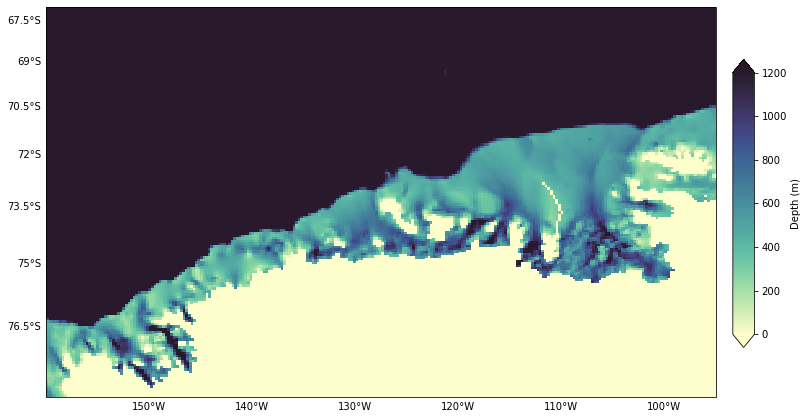

In [65]:
# These indices are based on eANT025; eventually should generalize based on lat, lon
mesh_sub  = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})
ax.set_extent([-95, -160, -78, -67], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

# lon_plt, lat_plt, var_plt = mask_land(mesh_sub, mesh_sub.bathy_metry)
img = ax.pcolormesh(mesh_sub.nav_lon, mesh_sub.nav_lat, mesh_sub.bathy_metry, 
                    transform=ccrs.PlateCarree(), rasterized=True, cmap=cmocean.cm.deep, vmin=0, vmax=1200)
cax = fig.add_axes([0.92, 0.25, 0.025, 0.5])    
plt.colorbar(img, cax=cax, extend='both', label='Depth (m)')

In [ ]:
# calculate annual cumulative sea ice production and compare with: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2007GL032903

In [8]:
# ice_growth = xr.where(nemo_ds.vfxice >= 0, np.nan, (nemo_ds.time_counter.dt.days_in_month*3600*24)*nemo_ds.vfxice*nemo_ds.area)
ice_growth = xr.where(nemo_ds.vfxice >= 0, np.nan, (nemo_ds.time_counter.dt.days_in_month*3600*24)*nemo_ds.vfxice)

# monthly growth:
ice_concentration = nemo_ds.siconc
monthly_iceconc   = ice_concentration.groupby('time_counter.month').mean('time_counter')
mean_monthly_iceconc = monthly_iceconc.assign_attrs({'long_name':'Monthly ice concentration'})

# monthly growth:
monthly_icegrowth   = ice_growth.groupby('time_counter.month').mean('time_counter')
masked_monthly      = xr.where(monthly_icegrowth>0, np.nan, -1*monthly_icegrowth)
mean_monthly_growth = masked_monthly.assign_attrs({'long_name':'Monthly ice growth (m/month)'})

# average over full time series:
annual_icegrowth   = ice_growth.groupby('time_counter.year').sum('time_counter')
annual_maxicevol   = nemo_ds.sivolu.groupby('time_counter.year').max('time_counter')
masked_annual      = xr.where(annual_icegrowth==0, np.nan, -1*annual_icegrowth)
mean_annual_growth = masked_annual.mean('year').assign_attrs({'long_name':'Annual ice growth (m/year)'})

# average 1992-2001 to compare with Tamura et al. (2008):
Tamura_icegrowth = ice_growth.sel(time_counter=slice('1992-01-01', '2002-01-01')).groupby('time_counter.year').sum('time_counter')
Tamura_ice_growth = xr.where(Tamura_icegrowth>=-4000, np.nan, -1*Tamura_icegrowth).mean('year')
# (time_counter, y, x) long_name : ice-ocean mass flux from ice melt/growth (neg = growth)

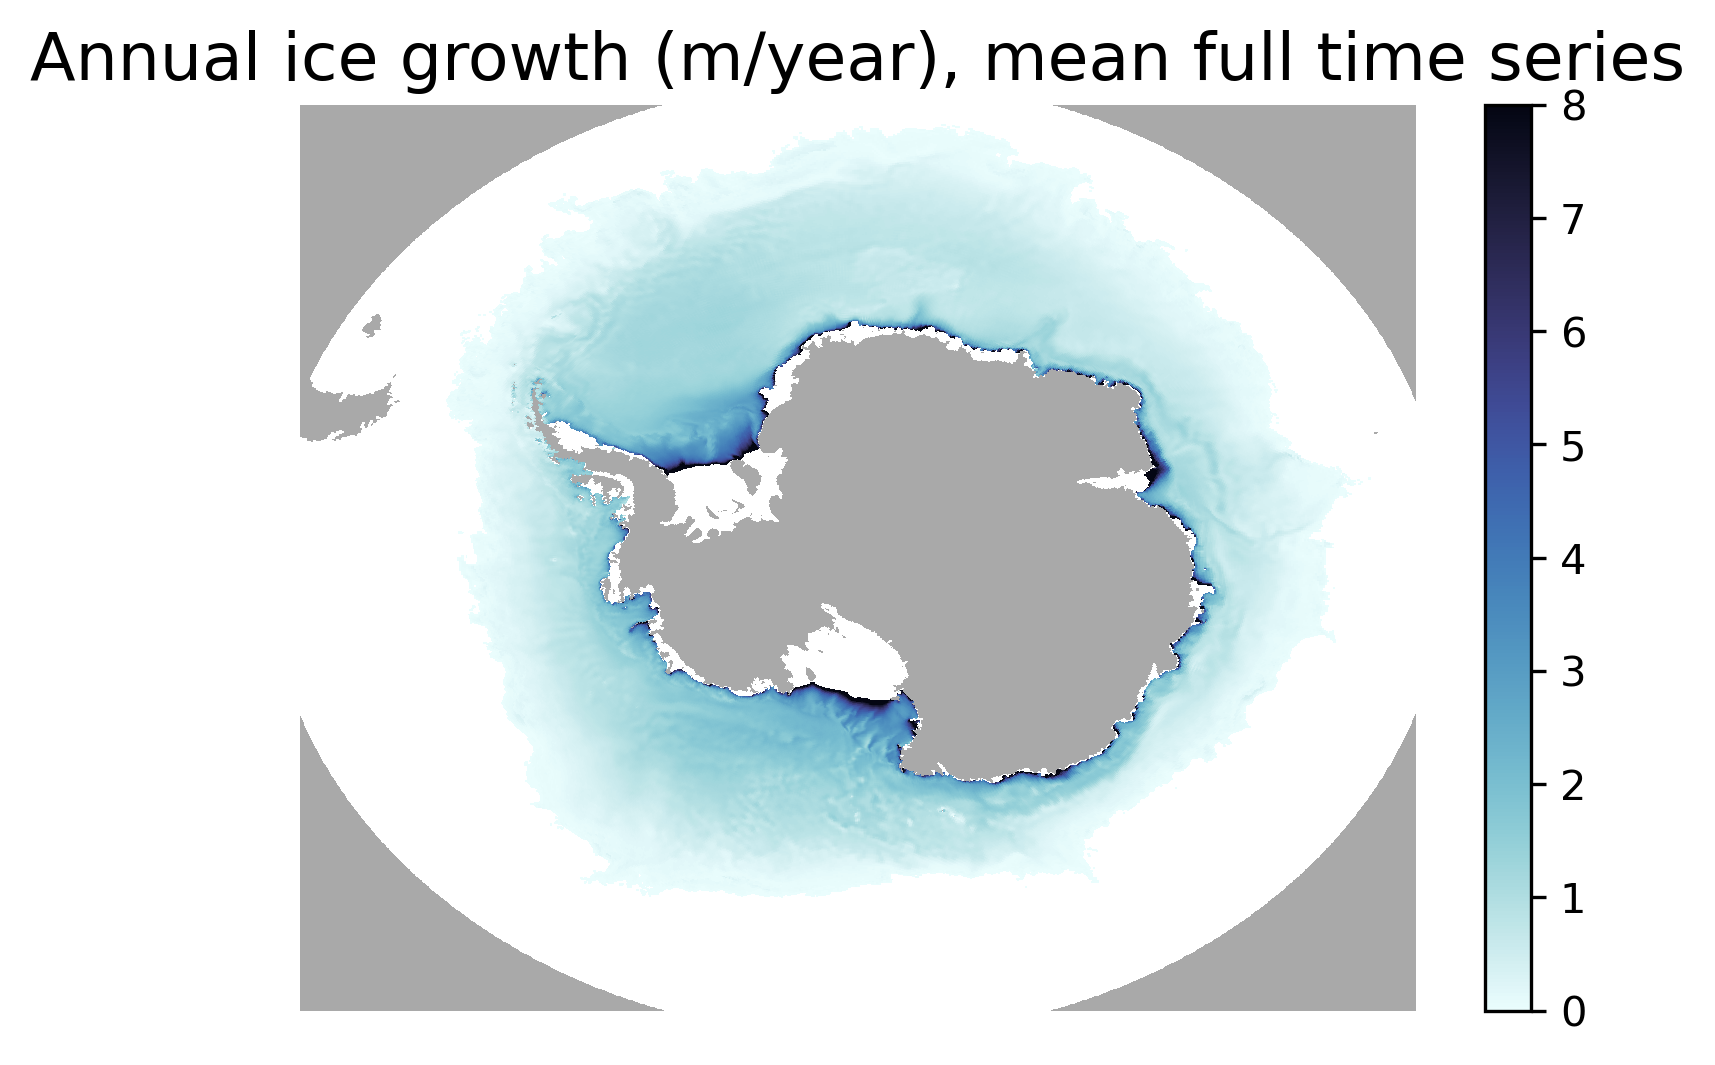

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=300)
circumpolar_plot(mean_annual_growth*1e-3, nemo_mesh_ds.isel(time_counter=0), ax=ax, make_cbar=True, return_fig=False, \
                 ctype=cmocean.cm.ice_r, lat_max=-52, vmin=0, vmax=8, title='Annual ice growth (m/year), mean full time series')
# fig.savefig('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/figures/annual_ice_growth.jpg')

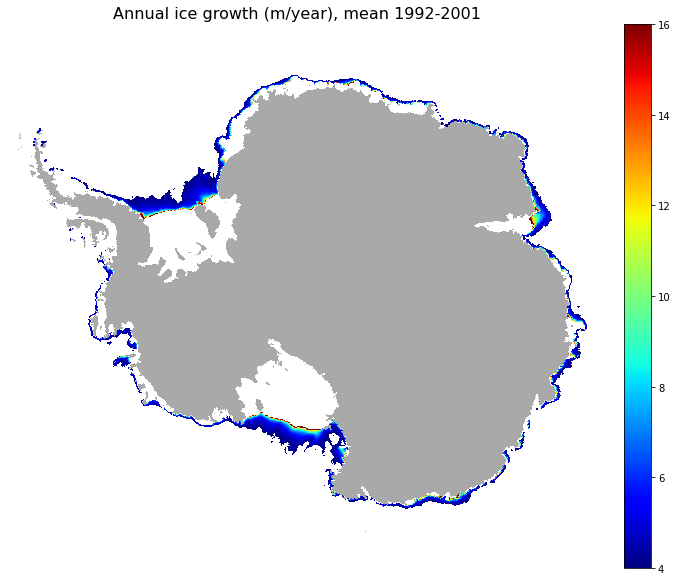

In [41]:
fig, ax = plt.subplots(1,1, figsize=(13,10))
circumpolar_plot(Tamura_ice_growth*1e-3, nemo_mesh_ds.isel(time_counter=0), ax=ax, make_cbar=True, return_fig=False, \
                 ctype='jet', lat_max=-65, vmin=4, vmax=16, title='Annual ice growth (m/year), mean 1992-2001')
# kg/m2/year * 1e-3 m3 / kg = m/year

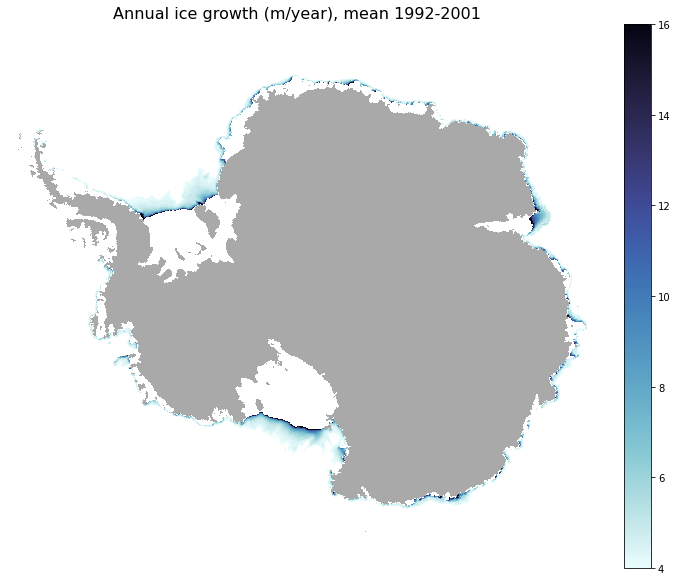

In [17]:
fig, ax = plt.subplots(1,1, figsize=(13,10))
circumpolar_plot(Tamura_ice_growth*1e-3, nemo_mesh_ds.isel(time_counter=0), ax=ax, make_cbar=True, return_fig=False, \
                 ctype=cmocean.cm.ice_r, lat_max=-65, vmin=4, vmax=16, title='Annual ice growth (m/year), mean 1992-2001')
# kg/m2/year * 1e-3 m3 / kg = m/year

(100.0, 453.0)

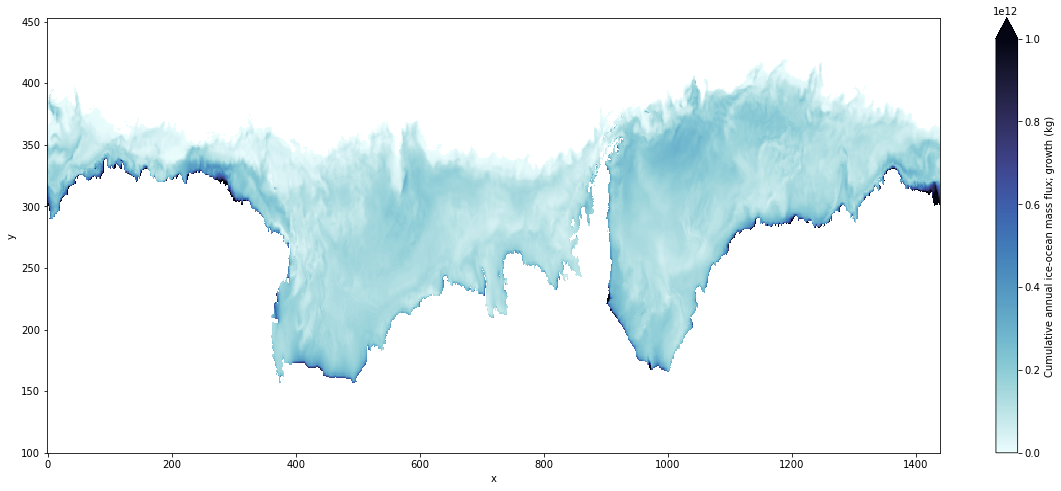

In [52]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
masked_ice_growth.plot(ax=ax, cmap=cmocean.cm.ice_r, vmin=0, vmax=1e12, \
                       cbar_kwargs={'label':'Cumulative annual ice-ocean mass flux; growth (kg)', 'extend':'max'})
ax.set_ylim(100,453)

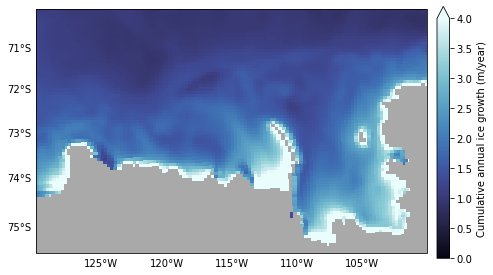

In [37]:
nemo_sub = nemo_mesh_ds.isel(time_counter=0,x=slice(450,900),y=slice(130,350))
ice_sub  = mean_annual_growth.isel(x=slice(450,900),y=slice(130,350))*1e-3

fig, ax = plt.subplots(1,1, figsize=(7,7), subplot_kw={'projection':ccrs.Mercator(latitude_true_scale=-70)})

ax.set_extent([-100, -130, -75.5, -70], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

lon_plt, lat_plt, var_plt    = plot_ocean(nemo_sub, ice_sub)
lon_land, lat_land, land_plt = plot_land(nemo_sub, annual_icegrowth.isel(year=0, x=slice(450,900),y=slice(130,350)))
img = ax.pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cmocean.cm.ice, vmin=0, vmax=4)
ax.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']))
# ax.set_title(title)
        
cax = fig.add_axes([0.92, 0.25, 0.025, 0.5])    
plt.colorbar(img, cax=cax, extend='max', label='Cumulative annual ice growth (m/year)')

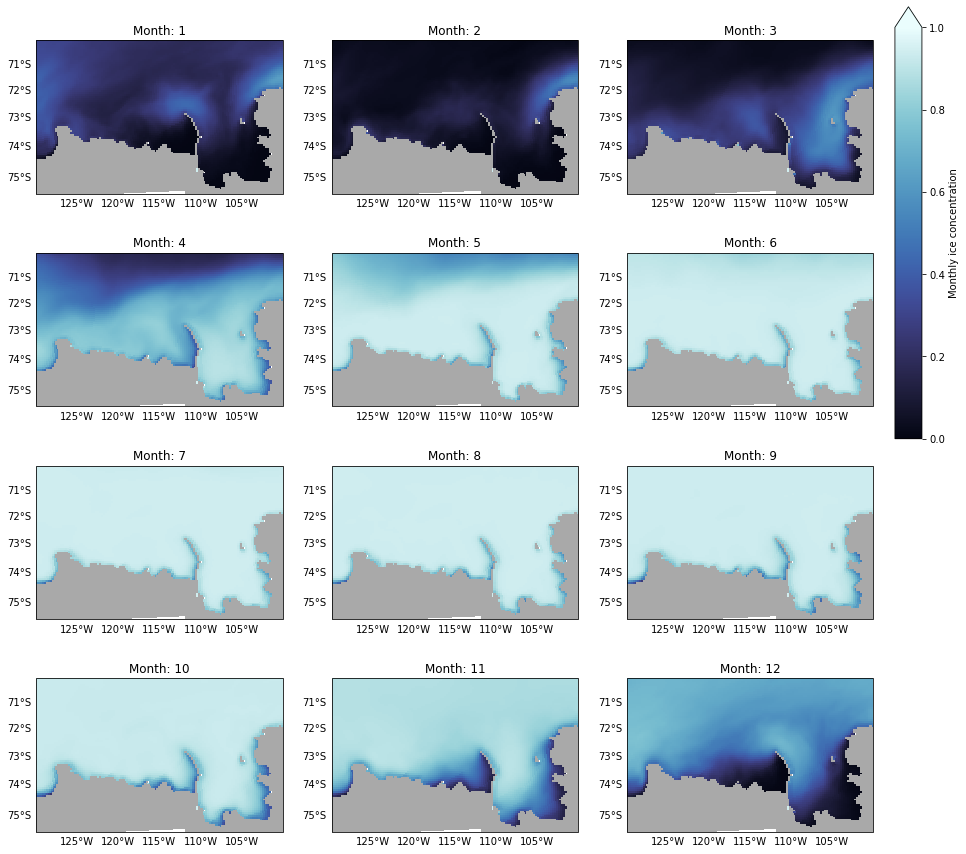

In [68]:
fig, ax = plt.subplots(4,3, figsize=(15,15), subplot_kw={'projection':ccrs.Mercator(latitude_true_scale=-70)})

nemo_sub = nemo_mesh_ds.isel(time_counter=0,x=slice(450,900),y=slice(130,350))
ice_sub  =  mean_monthly_iceconc.isel(x=slice(450,900),y=slice(130,350)) # mean_monthly_growth.isel(x=slice(450,900),y=slice(130,350))*1e-3

for axis in ax.ravel():
    axis.set_extent([-100, -130, -75.5, -70], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

for n, axis in enumerate(ax.ravel()):l
    lon_plt, lat_plt, var_plt    = plot_ocean(nemo_sub, ice_sub.isel(month=n))
    lon_land, lat_land, land_plt = plot_land(nemo_sub, ice_sub.isel(month=0))
    img = axis.pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cmocean.cm.ice, vmin=0, vmax=1)
    axis.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']))
    axis.set_title(f'Month: {n+1}')
    
cax = fig.add_axes([0.92, 0.5, 0.025, 0.4])    
plt.colorbar(img, cax=cax, extend='max', label='Monthly ice concentration')

### Visualize annual sea ice formation cycle and interannual variation

In [182]:
annual_maxicevol = nemo_ds.sivolu.groupby('time_counter.year').max('time_counter')

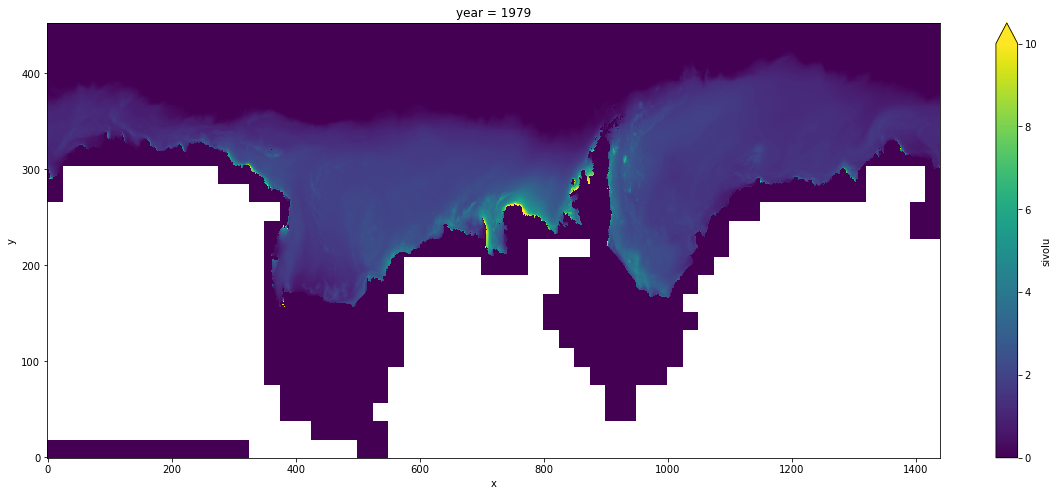

In [188]:
annual_maxicevol.isel(year=0).plot(figsize=(20,8), vmax=10)

### Compare maximum interannual sea ice extent in the model and based on satellite (do the same for total ice area)

1) Make function that identifies the 'continuous' ice edge for any particular month (plot on top of sea ice concencentration animation to check)
2) Identify annual maxima in ice extent (based on total ice area?) and plot as outlines of ice edge on one figure
3) Load similar information for satellite data

In [11]:
sea_ice_volume  = nemo_ds.sivolu * nemo_ds.area # sea-ice volume per area * area (not sure whether I still need to include the siconc fraction)
sea_ice_area    = nemo_ds.siconc * nemo_ds.area 
sea_ice_area_15 = xr.where(nemo_ds.siconc >=0.15, nemo_ds.siconc * nemo_ds.area, 0)

In [12]:
# calculate maximum sea ice area by year
annual_seaice_area  = sea_ice_area.sum(['y','x']).groupby('time_counter.year')
monthly_seaice_area = sea_ice_area.sum(['y','x']).groupby('time_counter.month') 

annual_seaice_area_15  = sea_ice_area_15.sum(['y','x']).groupby('time_counter.year')
monthly_seaice_area_15 = sea_ice_area_15.sum(['y','x']).groupby('time_counter.month') 

In [14]:
# load observations:
# NSIDC uses a 15% threshold for area
nsidc_files = glob.glob('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/NSIDC-obs/S_??_extent_v3.0.csv')
nsidc_ds    = pd.concat((pd.read_csv(f) for f in nsidc_files), ignore_index=True)
nsidc_ds.columns = list(map(str.lstrip, nsidc_ds)) # strip spaces from column names
# clean data:
nsidc_ds    = nsidc_ds.drop(nsidc_ds[nsidc_ds.year == 1978].index) # drop years with only partial data
nsidc_ds    = nsidc_ds.drop(nsidc_ds[nsidc_ds.year == 2024].index)
# nsidc_ds    = nsidc_ds.drop(nsidc_ds[nsidc_ds['area'] < 0].index)
nsidc_ds.loc[nsidc_ds['area'] < 0, 'area'] = np.nan

In [15]:
nsidc_annual_max_area = nsidc_ds.groupby('year')['area'].max()
nsidc_annual_min_area = nsidc_ds.groupby('year')['area'].min()
# nsidc_annual_min_area = nsidc_annual_min_area.drop(nsidc_annual_min_area[nsidc_annual_min_area < 0].index)

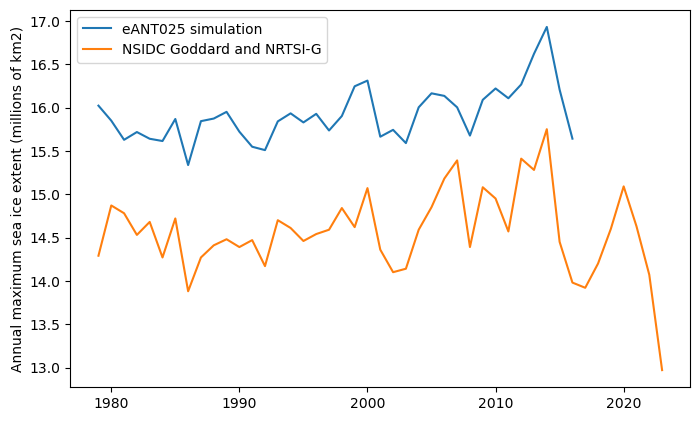

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8, 5), dpi=100) 
ax.plot(annual_seaice_area_15.max()['year'], annual_seaice_area.max().values*1e-6*1e-6, label='eANT025 simulation')
ax.plot(nsidc_annual_max_area, label='NSIDC Goddard and NRTSI-G')
ax.set_ylabel('Annual maximum sea ice extent (millions of km2)')#
ax.legend()

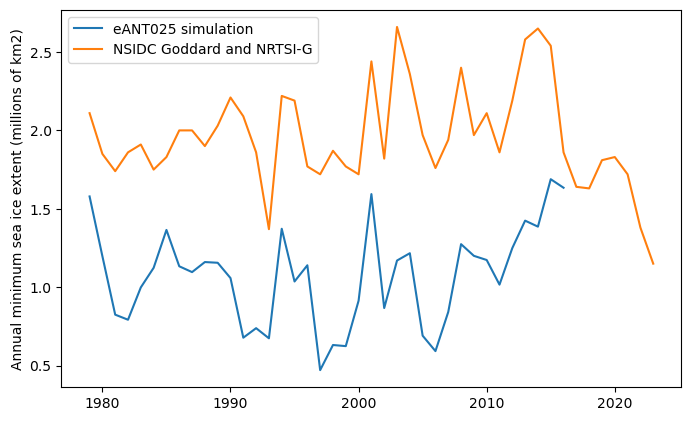

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8, 5), dpi=100) 
ax.plot(annual_seaice_area.min()['year'], annual_seaice_area.min().values*1e-6*1e-6, label='eANT025 simulation')
ax.plot(nsidc_annual_min_area, label='NSIDC Goddard and NRTSI-G')
ax.set_ylabel('Annual minimum sea ice extent (millions of km2)')
ax.legend()

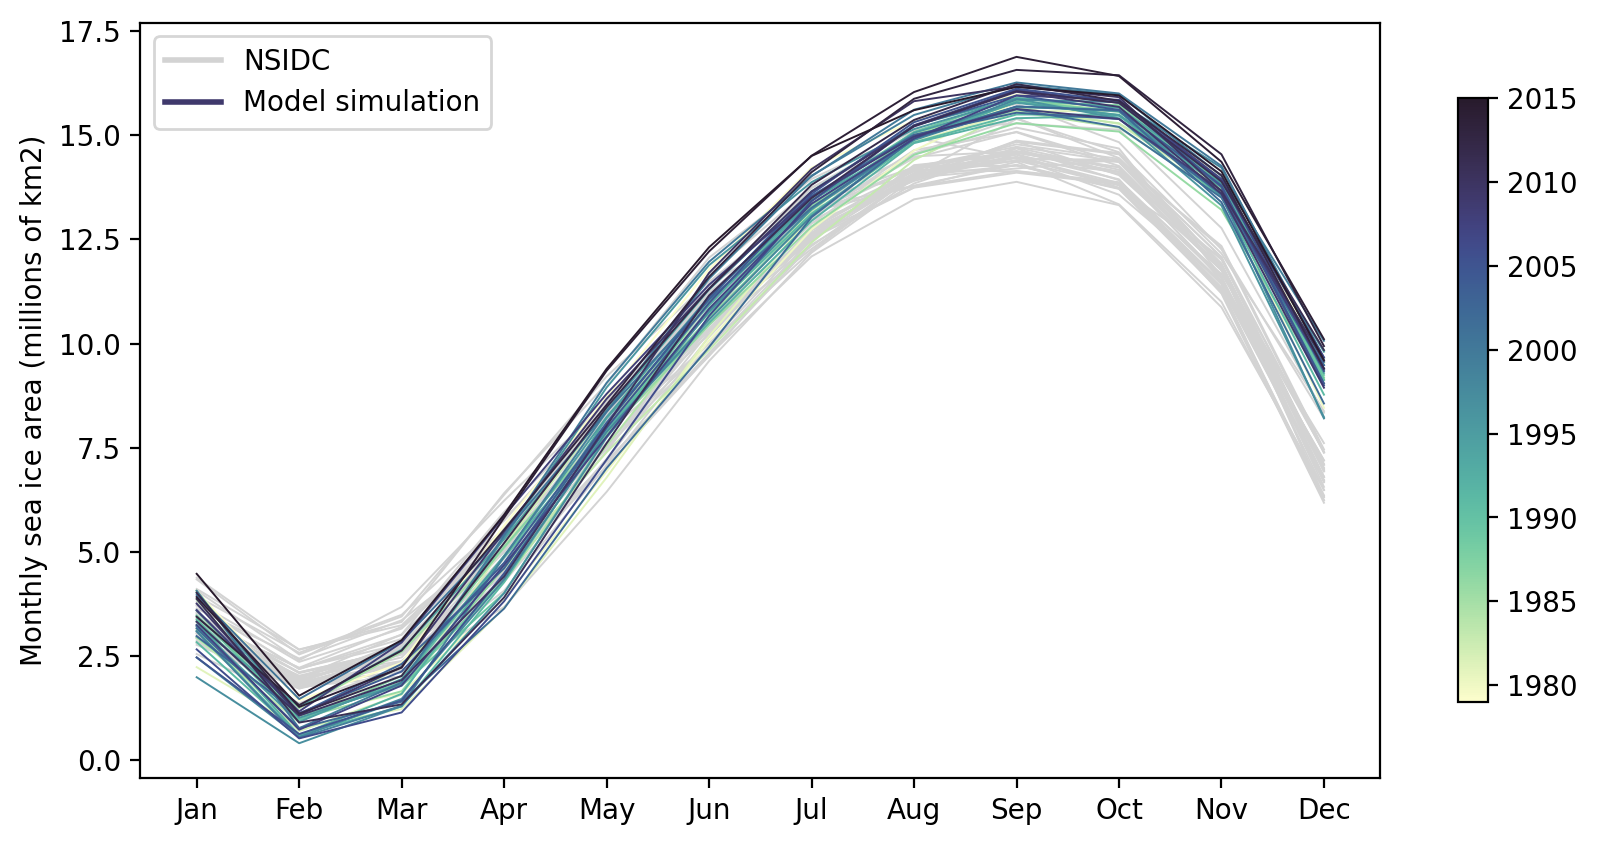

In [13]:
months = np.arange(1,13,1)

# Take colors at regular intervals spanning the colormap.
cmap   = cmocean.cm.deep # matplotlib.cm.get_cmap('viridis')
colors = cmap(np.linspace(0,1,len(range(1979,2016))))

SIarea_years = sea_ice_area_15['time_counter.year']

fig, ax = plt.subplots(1,1, figsize=(10, 5))#, dpi=200) 
ax.set_ylabel('Monthly sea ice area (millions of km2)')
for y, year in enumerate(range(1979, 2016)):
    SIarea_plot =  sea_ice_area_15.sum(['y','x'])[SIarea_years==year].values * 1e-6 * 1e-6
    if y==30:
        ax.plot(nsidc_ds[nsidc_ds['year']==year]['mo'], nsidc_ds[nsidc_ds['year']==year]['area'], label='NSIDC', \
                c='lightgray', linewidth=0.7, zorder=1);
        ax.plot(months, SIarea_plot, c=colors[y], linewidth=0.7, zorder=2, label='Model simulation'); 
    else:        
        ax.plot(nsidc_ds[nsidc_ds['year']==year]['mo'], nsidc_ds[nsidc_ds['year']==year]['area'], label='_nolegend_', \
                c='lightgray', linewidth=0.7, zorder=1);
        ax.plot(months, SIarea_plot, c=colors[y], linewidth=0.7, zorder=2, label='_nolegend_');
    
ax.set_xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1979, vmax=2015))
fig.colorbar(sm, ax=ax, shrink=0.8)

Text(0.5, 1.0, 'Monthly sea-ice area (millions of km2)')

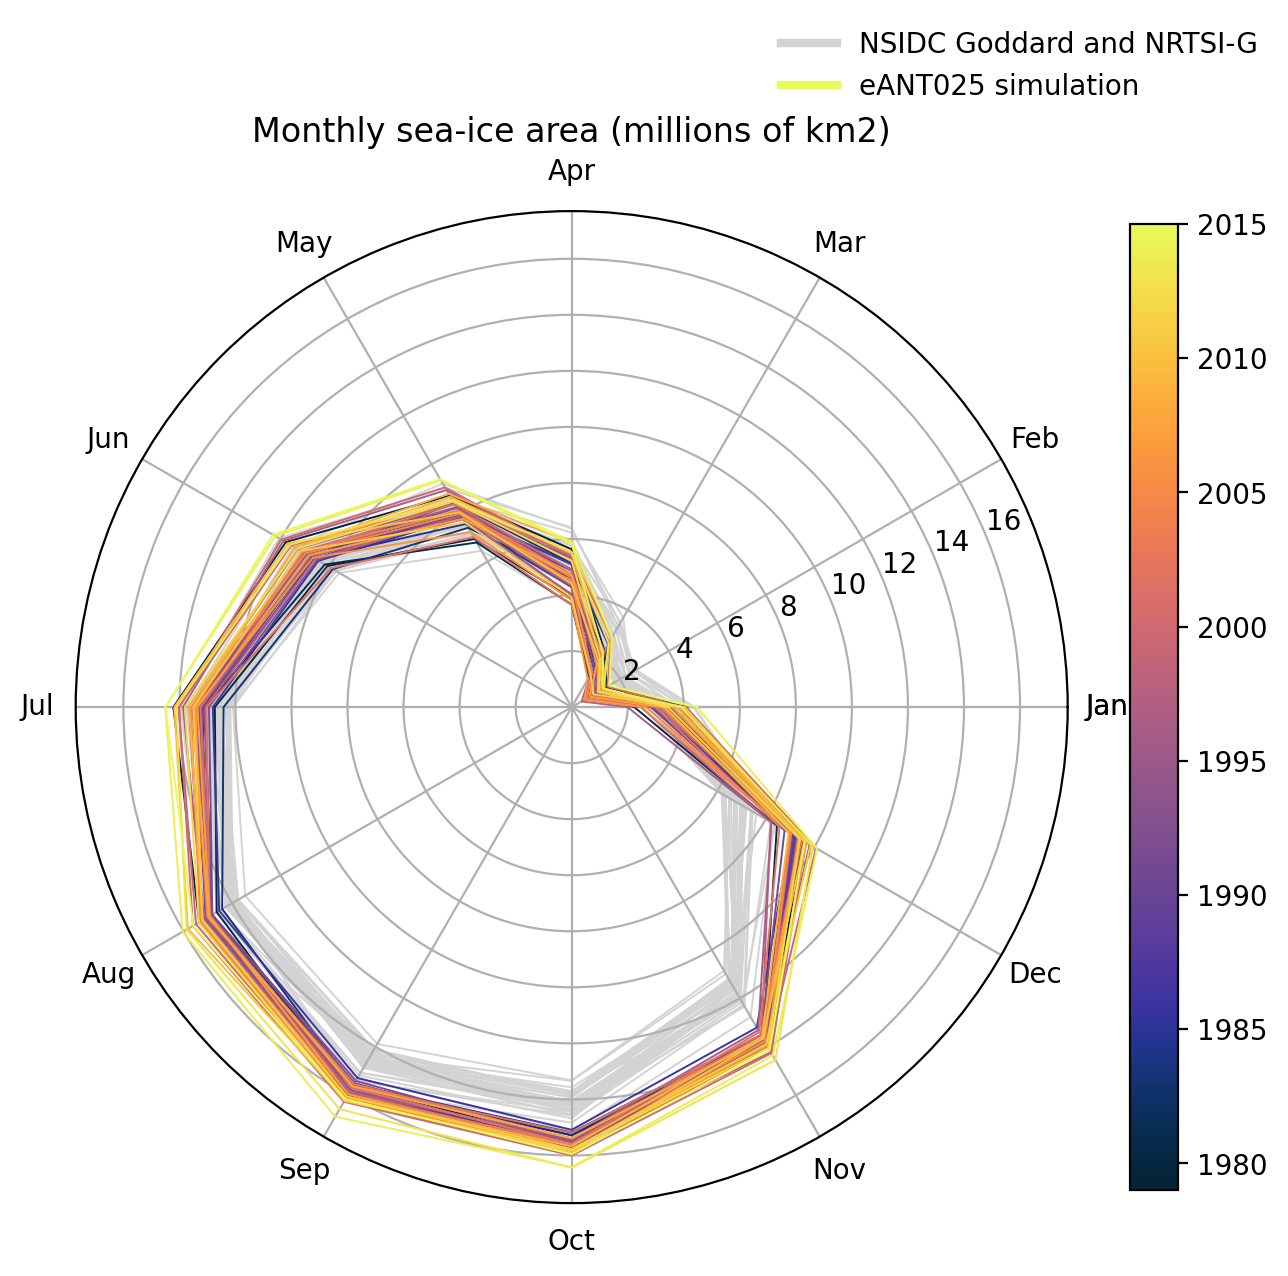

In [270]:
# Take colors at regular intervals spanning the colormap.
cmap   = cmocean.cm.thermal
colors = cmap(np.linspace(0,1,len(range(1979,2016))))

# plot monthly sea ice volume as circle for each year in the timeseries (color corresponds to year)
SIarea = sea_ice_area_15.sum(['y','x'])*1e-6*1e-6
SIarea_years = sea_ice_area_15['time_counter.year']
theta = np.linspace(0, 2*np.pi, 13)

# Take colors at regular intervals spanning the colormap.
cmap   = cmocean.cm.thermal
colors = cmap(np.linspace(0,1,len(range(1979,2016))))

# Polar Plot 
fig, ax = plt.subplots(1,1, figsize=(8, 8), subplot_kw={'projection': 'polar'}, dpi=200) 
for y, year in enumerate(range(1979, 2016)):
    nsidc_theta = np.append(0, (2*np.pi/12)*nsidc_ds[nsidc_ds['year']==year]['mo'])
    if year==2015:
        SIarea_plot = SIarea[SIarea_years==year].values
        ax.plot(nsidc_theta[0:-1], nsidc_ds[nsidc_ds['year']==year]['area'], label='NSIDC Goddard and NRTSI-G', \
                c='lightgray', linewidth=0.7, zorder=1);
        ax.plot(theta[0:-1], SIarea_plot, c=colors[y], linewidth=0.7, zorder=2, label='eANT025 simulation');
    else:
        SIarea_plot = np.append(SIarea[SIarea_years==year].values, SIarea[SIarea_years==year+1].values[0])
        nsidc_plot  = np.append(nsidc_ds[nsidc_ds['year']==year]['area'], \
                                nsidc_ds[(nsidc_ds['year']==year+1)*(nsidc_ds['mo']==1)]['area'])
        ax.plot(nsidc_theta, nsidc_plot, c='lightgray', linewidth=0.7, zorder=1, label='_nolegend_');
        ax.plot(theta, SIarea_plot, c=colors[y], linewidth=0.7, zorder=2, label='_nolegend_'); 
    
ax.set_xticks(theta, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']);

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1979, vmax=2015))
fig.colorbar(sm, ax=ax, shrink=0.8)
leg = ax.legend(loc=(0.7, 1.1), frameon=False)
for line in leg.get_lines():
    line.set_linewidth(3.0)

ax.set_title('Monthly sea-ice area (millions of km2)')

Text(0.5, 1.0, 'Monthly sea-ice volume (m3)')

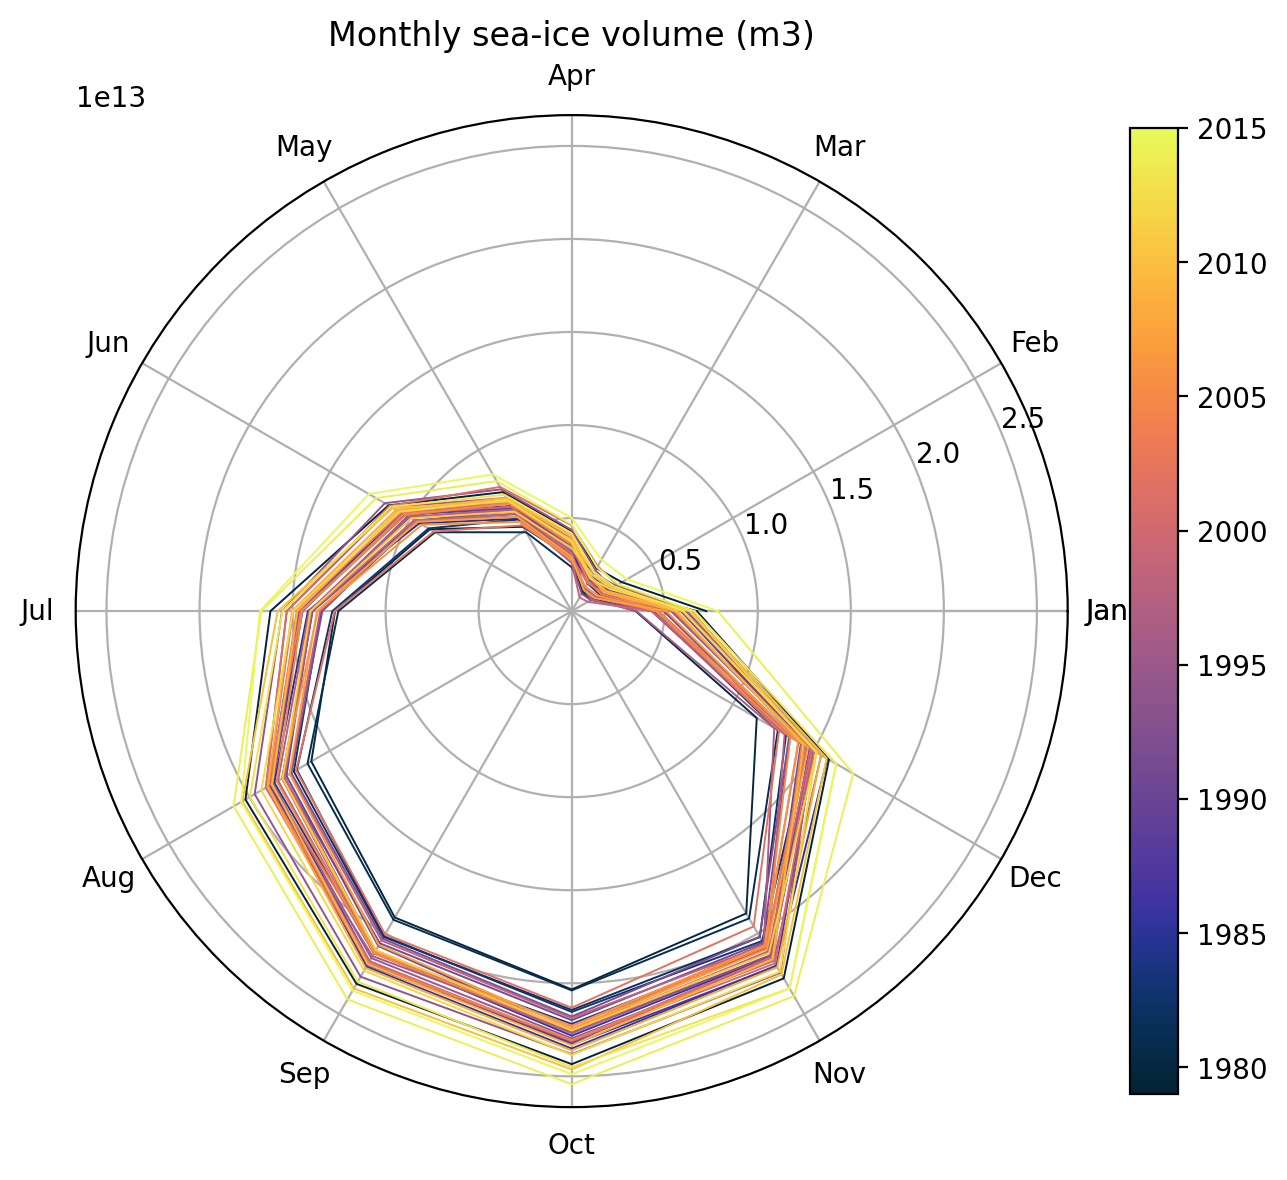

In [87]:
# plot monthly sea ice volume as circle for each year in the timeseries (color corresponds to year)
SIvol = sea_ice_volume.sum(['y','x'])
SIvol_years = sea_ice_volume['time_counter.year']
theta = np.linspace(0, 2*np.pi, 13)

# Take colors at regular intervals spanning the colormap.
cmap   = cmocean.cm.thermal
colors = cmap(np.linspace(0,1,len(range(1979,2016))))

# Polar Plot 
fig, ax = plt.subplots(1,1, figsize=(8, 8), subplot_kw={'projection': 'polar'}, dpi=200) 
for y, year in enumerate(range(1979, 2016)):
    if year==2015:
        SIvol_plot = SIvol[SIvol_years==year].values
        ax.plot(theta[0:-1], SIvol_plot, c=colors[y], linewidth=0.7);
    else:
        SIvol_plot =  np.append(SIvol[SIvol_years==year].values, SIvol[SIvol_years==year+1].values[0])
        ax.plot(theta, SIvol_plot, c=colors[y], linewidth=0.7); 
    
ax.set_xticks(theta, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']);

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1979, vmax=2015))
fig.colorbar(sm, ax=ax, shrink=0.8)

ax.set_title('Monthly sea-ice volume (m3)')
# Set y-axis limit to accommodate the data 
# ax.set_ylim(0, radii.max() + 10) 

### Visualize sea ice production and concentration for the Amundsen Sea
Evaluate seasonality and area with: https://tc.copernicus.org/articles/17/457/2023/tc-17-457-2023.pdf

In [190]:
nemo_ds.siconc

<xarray.DataArray 'siconc' (time_counter: 264, y: 453, x: 1440)>
dask.array<concatenate, shape=(264, 453, 1440), dtype=float32, chunksize=(12, 453, 1440), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(453, 1440), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(453, 1440), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 1979-01-16T12:00:00 ... 2000...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_ice_area_fraction
    long_name:           Sea-ice area fraction
    units:               
    online_operation:    average
    interval_operation:  1350 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 1350 s)
    cell_measures:       area: area

In [ ]:
# ice_growth = xr.where(nemo_ds.vfxice >= 0, np.nan, (nemo_ds.time_counter.dt.days_in_month*3600*24)*nemo_ds.vfxice*nemo_ds.area)
ice_conc = xr.where(nemo_ds.vfxice >= 0, np.nan, (nemo_ds.time_counter.dt.days_in_month*3600*24)*nemo_ds.vfxice)

# average over full time series:
annual_icegrowth = ice_growth.groupby('time_counter.year').sum('time_counter')
annual_maxicevol = nemo_ds.sivolu.groupby('time_counter.year').max('time_counter')
masked_ice_growth = xr.where(annual_ice_growth==0, np.nan, -1*annual_ice_growth)

In [82]:
def plot_amundsen_sea(fig, ax, var, title=None, ctype=cmocean.cm.ice, vlim=(0,1), nemo_mesh=nemo_mesh_ds, labelname=''):
    
    ax.set_extent([-95, -130, -75.5, -70], ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

    lon_plt, lat_plt, var_plt    = plot_ocean(nemo_mesh, var)
    lon_land, lat_land, land_plt = plot_land(nemo_mesh, var)
    img = ax.pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=ctype, vmin=vlim[0], vmax=vlim[1])
    ax.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']))
    ax.set_title(title)
        
    cax = fig.add_axes([0.92, 0.72, 0.025, 0.15])    
    plt.colorbar(img, cax=cax, extend='both', label=labelname)
    
    return fig, ax

In [65]:
nemo_sub = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(15,15), subplot_kw={'projection':ccrs.Mercator(latitude_true_scale=-70)})

plot_amundsen_sea(fig, ax[0,0], var.isel(time_counter=0, x=slice(450, 900), y=slice(130,350)), title='Month 1', nemo_mesh=nemo_sub)

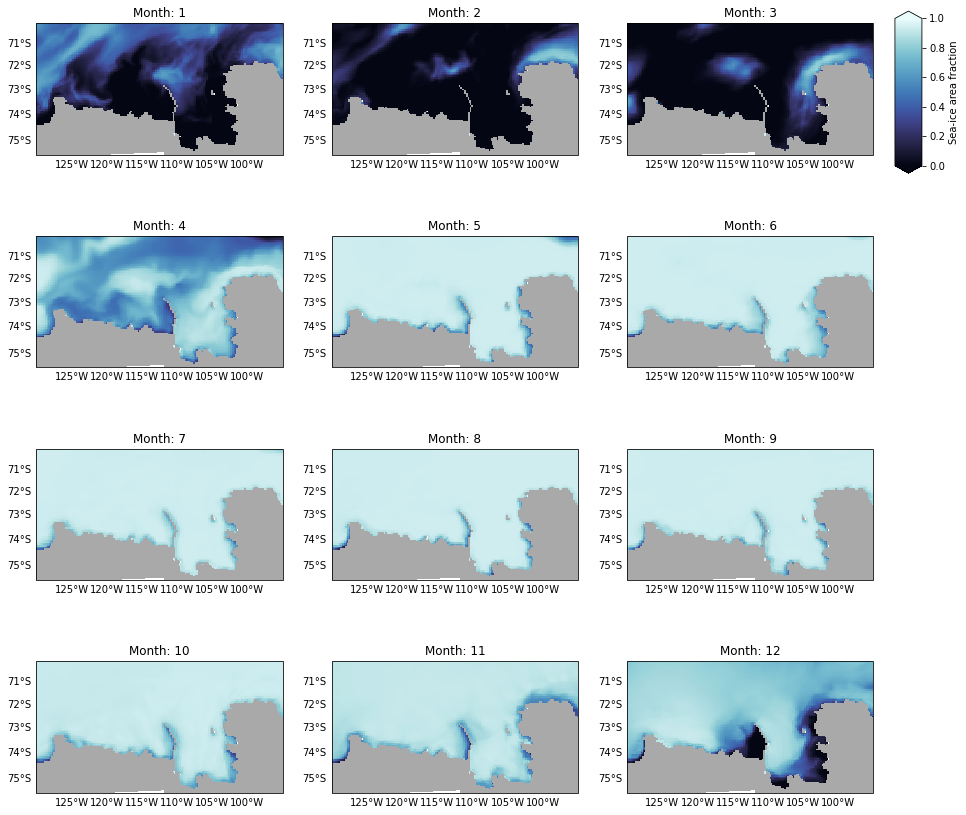

In [77]:
fig, ax = plt.subplots(4,3, figsize=(15,15), subplot_kw={'projection':ccrs.Mercator(latitude_true_scale=-70)})

for axis in ax.ravel():
    axis.set_extent([-95, -130, -75.5, -70], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

for month in range(0,12):
    lon_plt, lat_plt, var_plt    = mask_land(mesh_sub, sea_ice_ds.siconc.isel(time_counter=month, x=slice(450, 900), y=slice(130,350)))
    lon_land, lat_land, land_plt = plot_land(mesh_sub, sea_ice_ds.siconc.isel(time_counter=month, x=slice(450, 900), y=slice(130,350)))
    img = ax.ravel()[month].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cmocean.cm.ice, vmin=0, vmax=1)
    ax.ravel()[month].pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']))
    ax.ravel()[month].set_title(f'Month: {month+1}')
    
cax = fig.add_axes([0.92, 0.72, 0.025, 0.15])    
plt.colorbar(img, cax=cax, extend='both', label=sea_ice_ds.siconc.long_name)